## Johdanto datatieteeseen harjoitustyö 2021

# Tampereella myynnissä olevien kaksioiden hinnan ja sijainnin ennustaminen

Tämä tiedosto sisältää johdanto datatieteeseen kurssin harjoitustyön. Harjoitustyön tarkoituksena on kerätä dataa etuovi.com sivulta Tampereella myynnissä olevista kaksioista.

## Tarvittavat kirjastot

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time, os

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm
from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
from termcolor import colored as cl # text customization
from xgboost import XGBRegressor, XGBClassifier

## Datan kerääminen

In [ ]:
!scrapy genspider etuovi_scraper etuovi.com

In [ ]:
import scrapy

class EtuoviScraperSpider(scrapy.Spider):
    name = 'etuovi_scraper'
    allowed_domains = ['etuovi.com']
    # assing a product-review-page url below
    start_urls = ['https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1644131810']
    
    def parse(self, response):
        
        osoite = response.css('.flexboxgrid__col-xs-12__1I1LS.flexboxgrid__col-sm-7__1EzZq.flexboxgrid__col-md-9__2kjy7.flexboxgrid__col-lg-9__M7bfm.styles__infoArea__2yhEL > div.styles__cardTitle__14F5m > div.flexboxgrid__row__wfmuy > div > h4')
        
        kadut = []
        kaupunginosat = []
        for i in range(len(osoite)):
            osoite[i] = "".join(osoite[i].css('::text').extract()).strip()
            katu, kaupunginosa, kaupunki = osoite[i].split(', ')
            kadut.append(katu)
            kaupunginosat.append(kaupunginosa)

        hinta = response.css('.flexboxgrid__col-xs-12__1I1LS.flexboxgrid__col-sm-7__1EzZq.flexboxgrid__col-md-9__2kjy7.flexboxgrid__col-lg-9__M7bfm.styles__infoArea__2yhEL > div.styles__cardTitle__14F5m > div.styles__itemInfo__oDGHu > div > div.flexboxgrid__col-xs-4__p2Lev.flexboxgrid__col-md-4__2DYW- > span')
        
        for i in range(len(hinta)):
            hinta[i] = "".join(hinta[i].css('::text').extract()).strip()
            
        ala = response.css('.flexboxgrid__col-xs-12__1I1LS.flexboxgrid__col-sm-7__1EzZq.flexboxgrid__col-md-9__2kjy7.flexboxgrid__col-lg-9__M7bfm.styles__infoArea__2yhEL > div.styles__cardTitle__14F5m > div.styles__itemInfo__oDGHu > div > div.flexboxgrid__col-xs__26GXk.flexboxgrid__col-md-4__2DYW- > span')
            
        for i in range(len(ala)):
            ala[i] = "".join(ala[i].css('::text').extract()).strip()
            
        vuosi = response.css('.flexboxgrid__col-xs-12__1I1LS.flexboxgrid__col-sm-7__1EzZq.flexboxgrid__col-md-9__2kjy7.flexboxgrid__col-lg-9__M7bfm.styles__infoArea__2yhEL > div.styles__cardTitle__14F5m > div.styles__itemInfo__oDGHu > div > div.flexboxgrid__col-xs-3__3Kf8r.flexboxgrid__col-md-4__2DYW- > span')
            
        for i in range(len(vuosi)):
            vuosi[i] = "".join(vuosi[i].css('::text').extract()).strip()
            

        for i in range(len(osoite)):
            review = {
                'osoite': kadut[i],
                'kaupunginosa': kaupunginosat[i],
                'hinta': hinta[i],
                'koko': ala[i],
                'vuosi': vuosi[i],
            }
            yield review
            
        for i in range (2,27):    
            next_page_url = 'https://www.etuovi.com/myytavat-asunnot/tampere?haku=M1644131810&sivu=' + str(i)
            yield response.follow(next_page_url, self.parse)

In [ ]:
#Raavitaan data Etuovesta Scrapyn avulla
!scrapy runspider etuovi_scraper.py -o etuovi_results_new.json

## Datan tarkastelu ja siistiminen

In [32]:
df = pd.read_json('etuovi_results_new.json')

In [33]:
df.head()

,osoite,kaupunginosa,hinta,koko,vuosi
0,Ollinojankatu 4 D,Lielahti,125 000 €,"53,5 m²",1990
1,Kankurinkatu 8,Amuri,238 000 €,63 m²,1982
2,Härmälänkatu 30,Rantaperkiö,114 000 €,55 m²,1960
3,Satamakatu 17,Pyynikki,269 000 €,49 m²,2019
4,Pellervonkatu 22,Kaleva,173 000 €,50 m²,1965


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   osoite        750 non-null    object
 1   kaupunginosa  750 non-null    object
 2   hinta         750 non-null    object
 3   koko          750 non-null    object
 4   vuosi         750 non-null    object
dtypes: object(5)
memory usage: 29.4+ KB


Raavinnan seurauksena kaikkien tietueiden tietotyyppi on teksti. Datan käsittelyä varten poistetaan tyhjiä arvoja sisältävät rivit ja muutetaan numeeristen arvojen tietotyyppejä, sekä poistetaan datasta yksiköt.

In [35]:
#postetaan tyhjiä arvoja
df = df[df.hinta != '']
df = df[df.koko != '']
df = df[df.vuosi != '-']

In [36]:
#poistetaan €-merkki hinnasta ja muutetaan hinta float-arvoksiksi
df['hinta'] = df['hinta'].replace('[\€]','',  \
        regex=True).replace('[\\xa0]','', regex=True).replace('[\\,]','.', regex=True).astype(float)
df = df[df.hinta != 0]
#muutetaan vuosiluku int-arvoksi
df['vuosi'] = df['vuosi'].astype(int)
#poistetaan m²-merkki ja muutetaan pinta-ala float-arvoksi
df['koko'] = df['koko'].str.rstrip(' m²').replace(',','.', regex=True)
#poistetaan pinta-alat, joissa on kaki arvoa
df = df[df.koko != '42.5 / 48.5']
df = df[df.koko != '35.5 / 53.5']
df = df[df.koko != '68.5 / 94']
df = df[df.koko != '61 / 61.5']
df = df[df.koko != '70 / 100']
df = df[df.koko != '42.5 / 58.5']
df['koko'] = df['koko'].astype(float)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 733 entries, 0 to 749
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   osoite        733 non-null    object 
 1   kaupunginosa  733 non-null    object 
 2   hinta         733 non-null    float64
 3   koko          733 non-null    float64
 4   vuosi         733 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 34.4+ KB


In [37]:
df.head()

,osoite,kaupunginosa,hinta,koko,vuosi
0,Ollinojankatu 4 D,Lielahti,125000.0,53.5,1990
1,Kankurinkatu 8,Amuri,238000.0,63.0,1982
2,Härmälänkatu 30,Rantaperkiö,114000.0,55.0,1960
3,Satamakatu 17,Pyynikki,269000.0,49.0,2019
4,Pellervonkatu 22,Kaleva,173000.0,50.0,1965


Nyt sarakkeiden tietotyypit ovat kohdillaan ja yksiköt poistettu. Tarkastellaan vielä datan tilastollisia muuttujia.

In [38]:
df.describe()

,hinta,koko,vuosi
count,733.000000,733.000000,733.000000
mean,214021.790123,47.024420,2010.517053
std,85101.260025,9.571185,22.131285
min,12140.170000,22.000000,1880.000000
25%,168300.000000,40.000000,2015.000000
50%,201000.000000,46.500000,2022.000000
75%,252000.000000,53.000000,2022.000000
max,790000.000000,130.000000,2022.000000


Lasketaan asuntojen neliöhinnat ja lisätään ne omaan sarakkeeseen.

In [39]:
df['m2-hinta'] = df.hinta / df.koko

Visualisoidaan asuntojen kokojen, hintojen, sekä neliöhintojen jakaumat, sekä asuntojen jakauma kaupunginosittain.

/Users/senni/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/senni/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


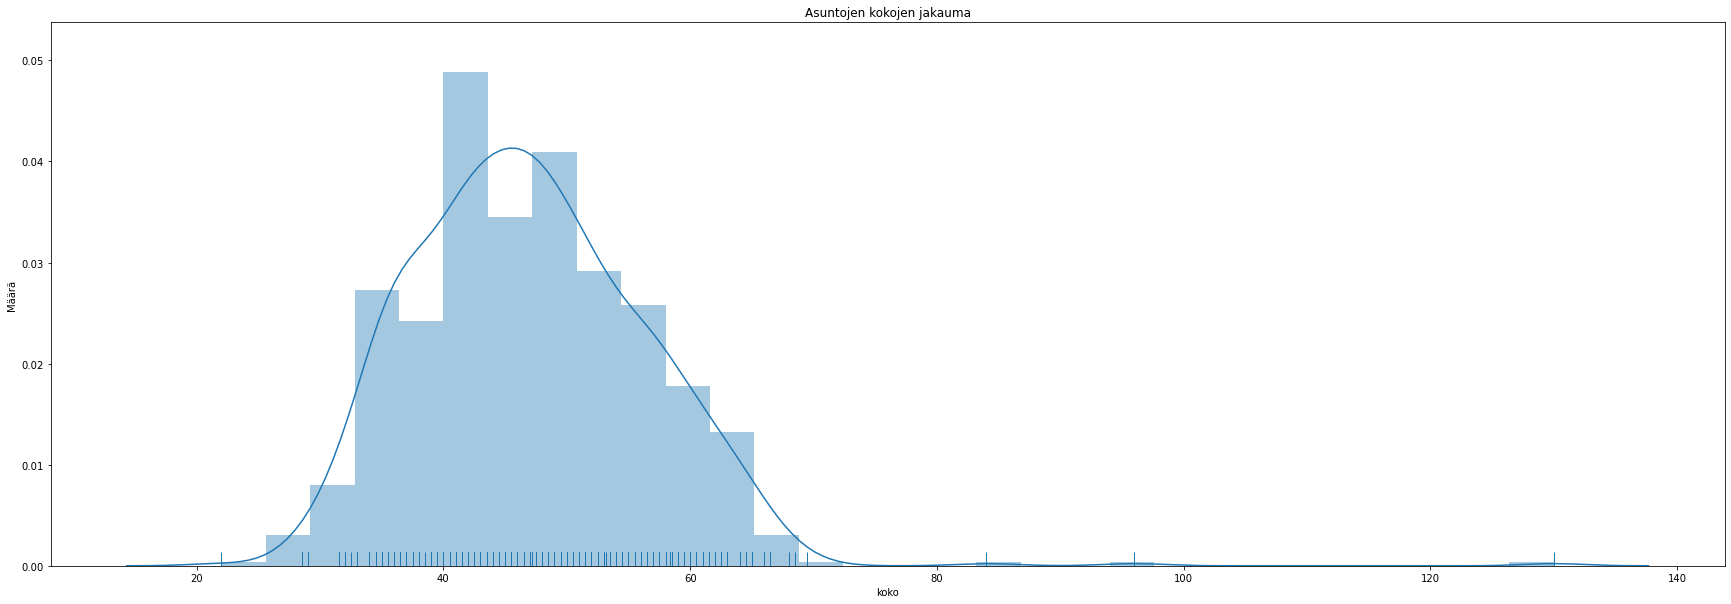

In [40]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen kokojen jakauma')
plt.xlabel('Asunnon koko neliömetreissä')
plt.ylabel('Määrä')
sns.distplot(df.koko, rug=True, bins=30);

Havaitaan asuntojen kokojen olevan suurimmaksi osaksi 30 ja 70 neliömetrin välillä. Havaitaan myös, että suurin osa asunnoista on noin 40 neliön kokoisia.

/Users/senni/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/senni/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


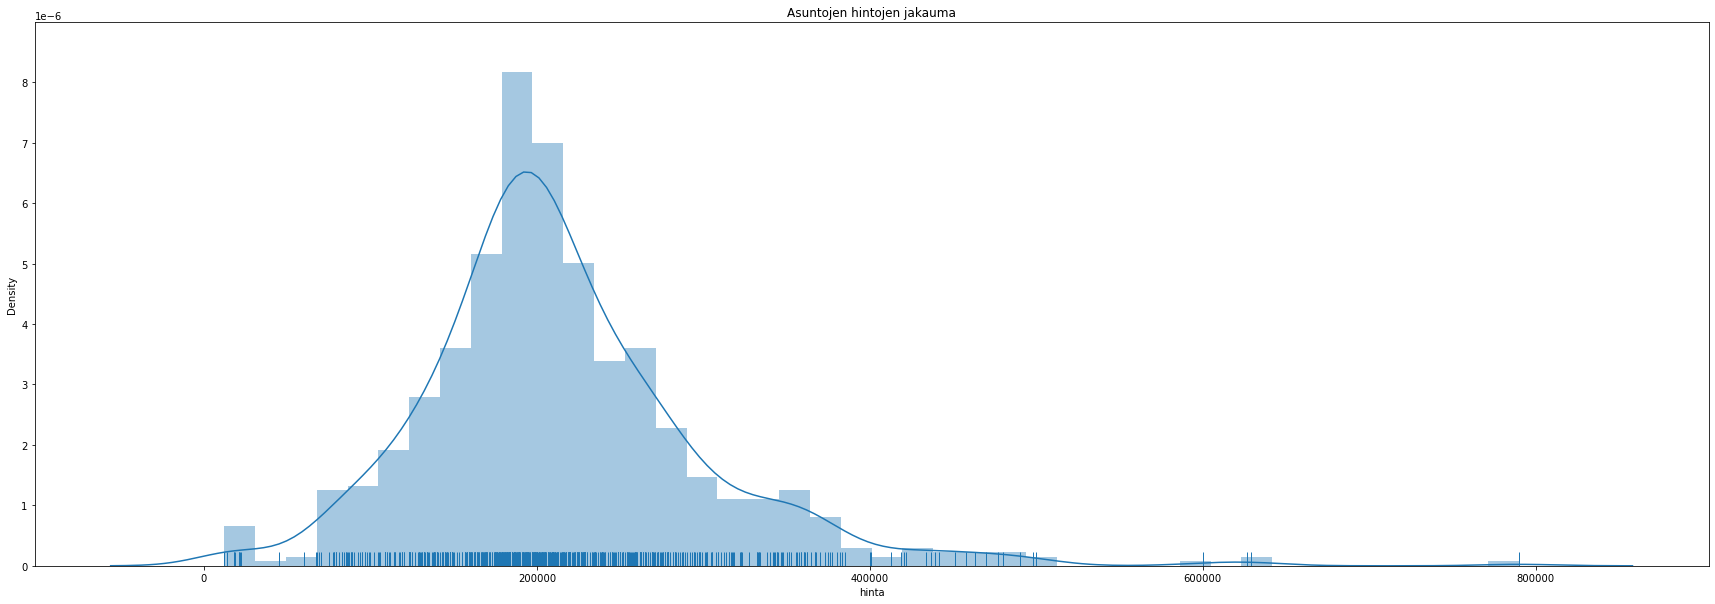

In [41]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen hintojen jakauma')
sns.distplot(df['hinta'], rug=True);

Kuvaajan mukaan asuntojen hinnat ovat yleisimmillään n. 200000 euroa ja hinnat jakautuvat normaalisti sen ympärille.

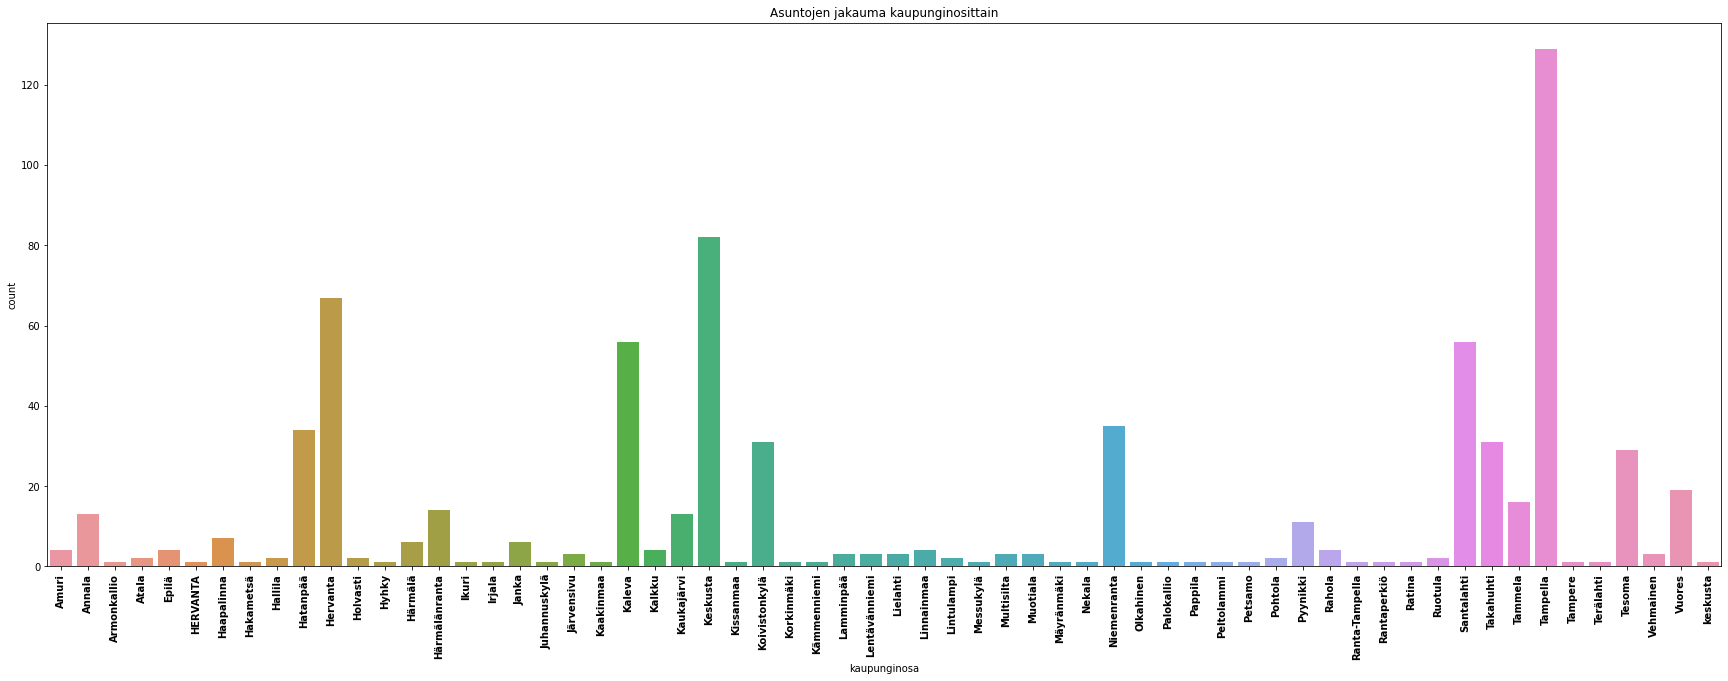

In [42]:
plt.figure(figsize=(30,10))
plt.title('Asuntojen jakauma kaupunginosittain')
sns.countplot(x=df.kaupunginosa.sort_values())
plt.xticks(weight='bold',rotation=90,);

Asuntoja näyttäisi olevan myynnissä eniten Tampellassa, Keskustassa ja Hervannassa. Tarjolla olevat asunnot eivät ole jakautuneet kovinkaan tasaisesti alueiden välille.

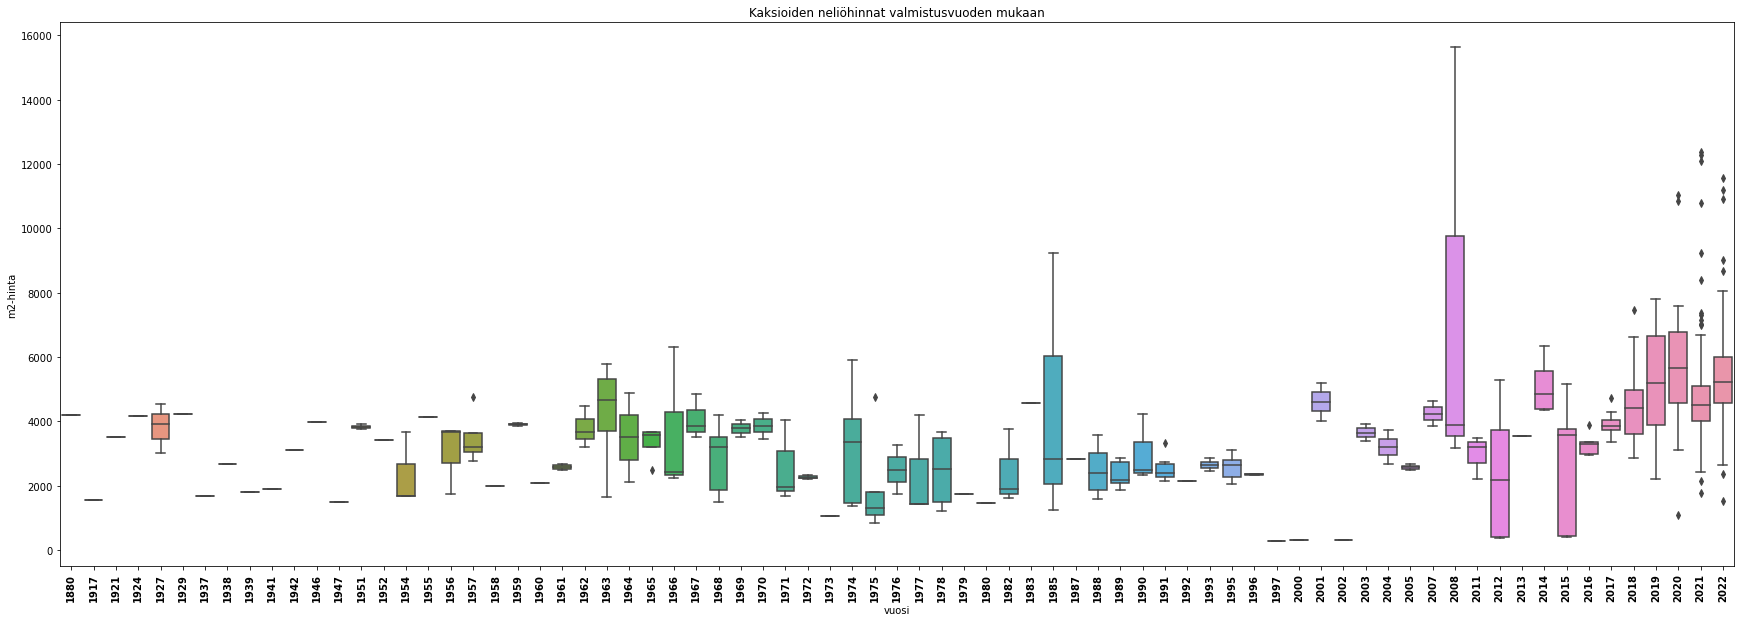

In [43]:
plt.figure(figsize=(30,10))
sns.boxplot(x=df.vuosi, y=df['m2-hinta']);
plt.title('Kaksioiden neliöhinnat valmistusvuoden mukaan')
plt.xticks(weight='bold',rotation=90);

Mielestäni neliöhintojen vertailussa on yllättävää, että 2010-luvun asunnoissa on kuvaajan mukaan näin paljon vaihtelua. Tästä voitaisiin melkein jopa päätellä datassa olevan virheitä. Sen sijaan 70-luvun asuntojen neliöhintojen alhaisuus ei ole yllättävää talojen elinkaaren vaiheeseen perustuen.

## Piirteiden tunnistaminen

Lisätään kaupunginosaa kuvaavalle sarakkeelle numeerinen muuttuja.

In [44]:
le = LabelEncoder()
print(f'Before:\n{df.dtypes}')

for col in df.columns:
    if df[col].dtype == 'object' and col != 'osoite':
        newColName = f'{col}_'
        fit = le.fit(df[col])
        df[newColName] = fit.transform(df[col])
print(f'\nAfter:\n{df.dtypes}')

Before:
osoite           object
kaupunginosa     object
hinta           float64
koko            float64
vuosi             int64
m2-hinta        float64
dtype: object

After:
osoite            object
kaupunginosa      object
hinta            float64
koko             float64
vuosi              int64
m2-hinta         float64
kaupunginosa_      int64
dtype: object


## Korrelaatioanalyysi

Etsitään heatmapin avulla korrelaatioita muuttujien välillä.

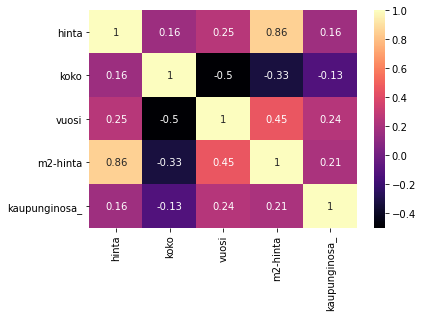

In [45]:
sns.heatmap(df.corr(), annot = True, cmap = 'magma')
plt.savefig('heatmap.png')
plt.show()

Kuvasta havaitaan, etteivät korrelaatiot ole kovinkaan vahvoja, mutta rakennusvuoden ja neliöhintojen välillä voidaan havaita olevan selkeä yhteys.

## Luokittelumalli

Tehdään luokittelumalli, jonka avulla voidaan ennustaa, missä kaupunginosassa voisi sijaita tietyn kokoinen ja tiettynä vuonna valmistunut kaksio. Aloitetaan määrittelemällä käytettävät muuttujat ja testaamalla Sklearnin RandomForestClassifier-mallia.

In [46]:
#Määritellään mallin käyttämät muuttujat ja jaetaan data train- ja test-setteihin
y = df.kaupunginosa
X_clf = df[[ 'koko', 'vuosi']]

X_train, X_test, y_train, y_test = train_test_split(X_clf, y, random_state=5)
', '.join(X_clf.columns)

'koko, vuosi'

In [47]:
#Sklearnin RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=1140, n_estimators=120 , max_depth=20, max_leaf_nodes=230)
rf_clf.fit(X_train, y_train)
result = rf_clf.predict(X_test)
print('RandomForestClassifier')
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result))

RandomForestClassifier
Confusion Matrix :
[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]]
Accuracy Score : 0.5489130434782609
Report : 
               precision    recall  f1-score   support

        Amuri       0.00      0.00      0.00         1
       Annala       0.50      0.14      0.22         7
  Armonkallio       0.00      0.00      0.00         1
        Epilä       0.00      0.00      0.00         1
   Haapalinna       1.00      0.33      0.50         3
      Hallila       0.00      0.00      0.00         0
     Hatanpää       0.67      0.57      0.62         7
     Hervanta       0.67      0.53      0.59        19
     Holvasti       0.00      0.00      0.00         1
      Härmälä       1.00      0.50      0.67         2
Härmälänranta       0.00      0.00      0.00         4
        Janka       0.33      0.50      0.40         2
 Juhannuskylä       0.00      0.00      0.00         1
       Kaleva       0

/Users/senni/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/senni/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Sklearnin RandomForestClassifierilla luokittelumallin tarkkuudeksi saadaan n. 55 %. Kokeillaan vielä XGBoostin XGBClassifieria paremman tarkkuuden saavuttamiseksi.

In [48]:
#XGBoostin XGBClassifier
xgb_clf = XGBClassifier(random_state=1140, n_estimators=120 , max_depth=20, max_leaf_nodes=230)
xgb_clf.fit(X_train, y_train)
result = xgb_clf.predict(X_test)
print('XGBClassifier')
print ('Confusion Matrix :') 
print(confusion_matrix(y_test, result)) 
print ('Accuracy Score :',accuracy_score(y_test, result)) 
print ('Report : ') 
print (classification_report(y_test, result))

/Users/senni/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:54:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "max_leaf_nodes" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[12:54:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier
Confusion Matrix :
[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 3]]
Accuracy Score : 0.5271739130434783
Report : 
               precision    recall  f1-score   support

        Amuri       0.00      0.00      0.00         1
       Annala       0.25      0.14      0

/Users/senni/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBClassifierin luokittelutarkkuudeksi saadaan n. 53 %. Havaitaan, ettei kummankaan mallin tarkkuus ole kovin kummoinen, mutta tämä on täysin ymmärrettävää kohtuullisen pienen datasetin takia. Paremman tarkkuuden saavutti sklearnin RandomForestClassifier 55% tarkkuudella, joten valitaan se toimeenpanovaiheen luokittelumalliksi. Tarkastellaan vielä miten eri valittu malli painottaa muuttujia kaupunginosan ennustamisessa.

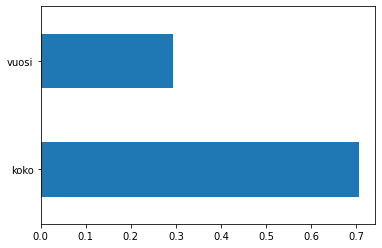

In [49]:
feat_importances = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

Näyttää, että malli painottaa kaupunginosan valinnassa kokoa valmistumisvuotta enemmän.

## Regressiomalli

Regressioanalyysissä pyritään ennustamaan asunnon hintaa koon, valmistumisvuoden ja kaupunginosan avulla. Aloitetaan määrittämällä käytettävät muuttujat ja testaamalla Sklearnin linear regression-algoritmia.

In [50]:
#Määritellään käytettävät muuttujat ja jaetaan data train- ja test-setteihin
y = df.hinta
X = df[['koko', 'vuosi', 'kaupunginosa_']] 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)
X_train.head()

,koko,vuosi,kaupunginosa_
398,49.5,2022,26
320,59.0,1959,24
358,34.5,2022,26
240,64.5,2022,24
337,57.5,1971,35


In [51]:
#Sklearnin LinearRegression-malli
time_start = time.time()

l_regr = LinearRegression()
l_regr.fit(X_train, y_train)

train_result = l_regr.predict(X_train)
test_result = l_regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)
print('LinearRegression')
print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

LinearRegression
Time taken to run: 0.0068 seconds

Training RMSE: 78090.2384
Testing RMSE: 73320.4485

Training R2: 0.1998
Testing R2: 0.112


Testatun mallin tarkkuus on huono, joten testataan vielä muutamia muita Sklearnin malleja paremman tarkkuuden saavuttamiseksi.

In [52]:
# 1. OLS

ols = LinearRegression()
ols.fit(X_train, y_train)
ols_yhat = ols.predict(X_test)

# 2. Ridge

ridge = Ridge(alpha = 0.5)
ridge.fit(X_train, y_train)
ridge_yhat = ridge.predict(X_test)

# 3. Lasso

lasso = Lasso(alpha = 0.01)
lasso.fit(X_train, y_train)
lasso_yhat = lasso.predict(X_test)

# 4. Bayesian

bayesian = BayesianRidge()
bayesian.fit(X_train, y_train)
bayesian_yhat = bayesian.predict(X_test)

# 5. ElasticNet

en = ElasticNet(alpha = 0.01)
en.fit(X_train, y_train)
en_yhat = en.predict(X_test)

# EVALUATION

# 1. Explained Variance Score

print(cl('EXPLAINED VARIANCE SCORE:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of OLS model is {}'.format(evs(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Ridge model is {}'.format(evs(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Lasso model is {}'.format(evs(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of Bayesian model is {}'.format(evs(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('Explained Variance Score of ElasticNet is {}'.format(evs(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

# 2. R-squared

print(cl('R-SQUARED:', attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of OLS model is {}'.format(r2(y_test, ols_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Ridge model is {}'.format(r2(y_test, ridge_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Lasso model is {}'.format(r2(y_test, lasso_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of Bayesian model is {}'.format(r2(y_test, bayesian_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

print(cl('R-Squared of ElasticNet is {}'.format(r2(y_test, en_yhat)), attrs = ['bold']))

print('-------------------------------------------------------------------------------')

EXPLAINED VARIANCE SCORE:
-------------------------------------------------------------------------------
Explained Variance Score of OLS model is 0.11629975568399598
-------------------------------------------------------------------------------
Explained Variance Score of Ridge model is 0.11630025227692842
-------------------------------------------------------------------------------
Explained Variance Score of Lasso model is 0.1162997586604122
-------------------------------------------------------------------------------
Explained Variance Score of Bayesian model is 0.11738405597371027
-------------------------------------------------------------------------------
Explained Variance Score of ElasticNet is 0.11630248275931754
-------------------------------------------------------------------------------
R-SQUARED:
-------------------------------------------------------------------------------
R-Squared of OLS model is 0.11201379804436395
-------------------------------------------

Saadut tulokset ovat edelleen huonoja, joten testataan vielä XGBoostin XGBRegressor-mallia

In [53]:
#XGBoostin XGBRegressor

time_start = time.time()

xgb_regr = XGBRegressor()
xgb_regr.fit(X_train, y_train )

train_result = xgb_regr.predict(X_train)
test_result = xgb_regr.predict(X_test)

time_end = time.time()

rmse_train = mean_squared_error(y_train, train_result, squared=False)
r2_train = r2_score(y_train, train_result)

rmse_test = mean_squared_error(y_test, test_result, squared=False)
r2_test = r2_score(y_test, test_result)
print('XGBRegressor')
print(f"Time taken to run: {round(time_end - time_start, 4)} seconds")
print("\nTraining RMSE:", round(rmse_train,4))
print("Testing RMSE:", round(rmse_test,4))
print("\nTraining R2:", round(r2_train,4))
print("Testing R2:", round(r2_test,4))

XGBRegressor
Time taken to run: 0.1876 seconds

Training RMSE: 30744.6335
Testing RMSE: 56356.9679

Training R2: 0.876
Testing R2: 0.4754


/Users/senni/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


Regressiomalleista selkeästi paras tulos saatiin XGBRegression-algoritmilla. Valitaan se siis toimeenpano-osuuteen. Tarkastellaan vielä, mitä muuttujia XGBRegressor painotti analyysissä.

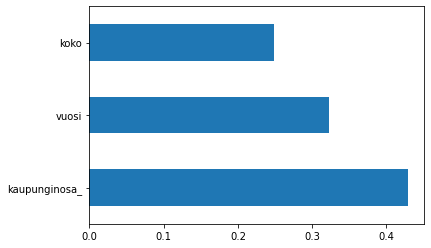

In [54]:
feat_importances = pd.Series(xgb_regr.feature_importances_, index=X_train.columns)
feat_importances.nlargest().plot(kind='barh');

Näyttää, että regressioalgoritmi painottaa kaikkia muuttujia melko tasaisesti, mutta eniten painoarvoa on kaupunginosalla.

## Toimeenpano

Tehdään järjestelmä, joka ennustaa tietyn kokoisen ja tiettynä vuonna valmistuneen kaksion sijainnin ja myyntihinnan. Käytetään testisyötteenä 55 neliön kokoista asuntoa, joka on valmistunut vuonna 2019.

In [55]:
# Testisyöte
clf_test_values = {
    'koko': [55],
    'vuosi': [2019],    
}

clf_test_df = pd.DataFrame(clf_test_values)
clf_result = rf_clf.predict(clf_test_df) # Alueen luokittelu
prob = rf_clf.predict_proba(clf_test_df).max()

print("Predicted area: {} with certainty of {:f}.\n".format(', '.join(clf_result), prob) )

regr_test_df = clf_test_df
regr_test_df['kaupunginosa_'] = df[df.kaupunginosa==clf_result[0]].kaupunginosa_.values[0]
regr_result = xgb_regr.predict(regr_test_df) # Hinnan arvio
print(f'Predicted price: {round(regr_result[0],2)}€')

print(f"\n{', '.join(clf_result)} info:")
df[df.kaupunginosa == clf_result[0]].describe()

Predicted area: Keskusta with certainty of 0.583333.

Predicted price: 345588.1875€

Keskusta info:


,hinta,koko,vuosi,m2-hinta,kaupunginosa_
count,82.000000,82.000000,82.000000,82.000000,82.0
mean,320733.597561,52.134146,2007.573171,6395.867187,24.0
std,102245.530092,13.434121,27.598099,2137.436475,0.0
min,69000.000000,34.500000,1917.000000,1095.238095,24.0
25%,256650.000000,43.500000,2019.250000,4981.785346,24.0
50%,327190.000000,51.000000,2022.000000,6897.415039,24.0
75%,366780.000000,56.875000,2022.000000,7283.013816,24.0
max,629000.000000,130.000000,2022.000000,12296.296296,24.0


Malli ennustaa annetuilla lähtöarvoilla asunnon sijaitsevan Keskustassa 58 % todennäköisyydellä ja asunnon myyntihinnaksi n. 345588 €. Hinta vaikuttaa Keskustan alueen kaksioille järkevältä, hieman mediaanihintaa korkeammalta. Kaupunginosalle laskettu todennäköisyys ei ole kovinkaan suuri, mutta käytetyllä datamäärällä kovinkaan paljon korkeampiin todennäköisyyksiin ei päästy muillakaan testisyötteillä. Jos mallia haluaisi tarkentaa tulisi ensimmäisenä kerätä lisää dataa.